# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [8]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv('example.env')

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [9]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [10]:
# Display sample data
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [11]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
daily_returns.head()


,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [12]:
# Compute daily volatility 

avg_daily_return_agg = daily_returns.mean()["AGG"]["close"]
avg_daily_return_spy = daily_returns.mean()["SPY"]["close"]

std_dev_daily_return_agg = daily_returns.std()["AGG"]["close"]
std_dev_daily_return_spy = daily_returns.std()["SPY"]["close"]
std_dev_daily_return_spy

0.007820053413439366

In [13]:
# Save the last day's closing price
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]
spy_last_price

321.92

In [14]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [15]:
# Run the Monte Carlo Simulation
for n in range(number_simulations):
    simulated_price_df = pd.DataFrame()
   
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252*30 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)

    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()

    #print(simulated_daily_returns)
    
    # Set the portfolio weights (40% AGG; 60% SPY)
    weights = [0.40, 0.60]

    # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    monte_carlo[f"Simulation {n+1}"] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
monte_carlo.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 491,Simulation 492,Simulation 493,Simulation 494,Simulation 495,Simulation 496,Simulation 497,Simulation 498,Simulation 499,Simulation 500
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000476,1.000536,0.998808,1.005394,1.011797,0.994452,0.997251,1.013277,1.000869,0.995376,...,1.002066,0.992709,1.001801,1.002671,0.996472,1.003160,1.001638,1.006800,0.998173,0.994765
2,1.008876,1.004699,1.003590,0.996711,1.009571,0.994247,0.994214,1.007199,1.000225,0.993036,...,1.005759,0.994517,1.003317,1.006181,0.997472,0.991774,1.002764,1.005408,0.996137,0.998871
3,1.008286,1.004228,1.003770,0.998232,1.007751,0.987669,0.998229,1.001361,1.000230,1.001279,...,1.006771,0.988444,1.004118,1.010565,0.993293,0.994454,1.008272,0.999144,0.998656,1.003328
4,1.013963,1.006575,1.008493,1.002636,1.013664,0.990972,1.003241,0.995491,1.002048,1.006036,...,1.004196,0.992123,1.004724,1.004423,0.994844,0.993782,1.005722,1.002248,0.996964,1.004095


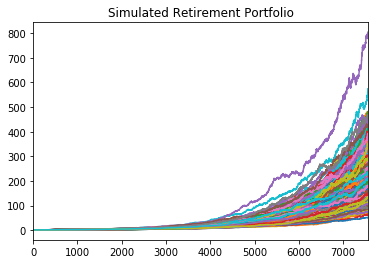

In [18]:
# Visualize the Simulation
monte_carlo.plot(legend=None, title="Simulated Retirement Portfolio")
#plt.savefig('./Images/simulated_cumulative_returns.png')

In [19]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = monte_carlo.iloc[-1, :]
ending_cumulative_returns.head()

Simulation 1    192.773859
Simulation 2    171.964137
Simulation 3    177.998514
Simulation 4    138.466715
Simulation 5    175.628015
Name: 7560, dtype: float64

In [20]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    102.825606
0.95    379.341808
Name: 7560, dtype: float64

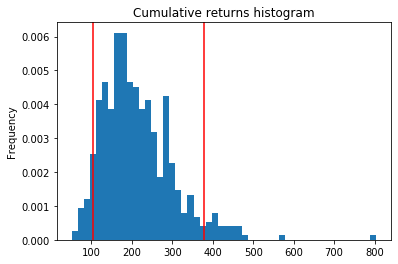

In [22]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind="hist", title = "Cumulative returns histogram", density=True, bins=50)
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")
#plt.savefig('./Images/ending_returns_hist.png')

In [25]:
ending_cumulative_returns.quantile(q=[0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8, 0.90,1.0])

0.1    119.027485
0.2    141.133704
0.3    163.215637
0.4    179.248286
0.5    199.083857
0.6    219.800399
0.7    245.308250
0.8    281.346135
0.9    320.561549
1.0    804.011725
Name: 7560, dtype: float64

In [27]:
len(ending_cumulative_returns)

500

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [61]:
# Compute cumulative returns
cumulative_returns_percentiles = ending_cumulative_returns.quantile(q=[0.1, 0.5, 0.90])
print(f"Expected cumulative returns at 30 years for 10th, 50th and 90th percentiles: \n{cumulative_returns_percentiles}")

Expected cumulative returns at 30 years for 10th, 50th and 90th percentiles: 
0.1    119.029858
0.5    199.089970
0.9    320.549831
Name: 7560, dtype: float64


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [62]:
# Set initial investment
initial_investment = 20000

# Compute expected portfolio return
cumulative_pnl = initial_investment * cumulative_returns_percentiles
cumulative_pnl.astype(int)

0.1    2380597
0.5    3981799
0.9    6410996
Name: 7560, dtype: int64

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

Given the current projected annual income from the Plaid analysis, will a 4% withdrawal rate meet or exceed that value at the 10th percentile? Note: This is basically determining if retirement income is equivalent to current income. To simplify this analysis, compare the Plaid projected annual income to first year retirement income. To conduct this analysis, multiple the ending return at the 10th percentile by the 4% withdrawal rate and compare it to the projected income.

In [63]:
# Set Plaid's projected income
projected_income = 7389

# Calculate the 4% withdrawal for the ending return as retirement income
return_withdrawal = int(cumulative_pnl.iloc[0]*0.04)
return_withdrawal 
# Determine if the retirement income meets or exceeds the current projected income
if projected_income >= return_withdrawal:
    print(f"The 4% withdrawal at the 10th percentile is ${return_withdrawal}, which is less than projected income of ${projected_income}, so there will be too little funds by retirement")
else:
    print(f"The 4% withdrawal at the 10th percentile is ${return_withdrawal}, which is more than projected income of ${projected_income}, so there should be sufficient funds at retirement")
    

The 4% withdrawal at the 10th percentile is $95223, which is more than projected income of $7389, so there should be sufficient funds at retirement


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [64]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
increased_investment = initial_investment*1.5
increased_investment

# Calculate expected portfolio return with incresed investment amount
increased_cumulative_pnl = increased_investment * cumulative_returns_percentiles

# Calculate the 4% withdrawal for the ending return as retirement income
return_withdrawal_increased = int(increased_cumulative_pnl.iloc[0]*0.04)
return_withdrawal_increased

# Determine if the retirement income meets or exceeds the current projected income
if projected_income >= return_withdrawal_increased:
    print(f"After an increased investment of 50%, the 4% withdrawal at the 10th percentile is ${return_withdrawal_increased}, which is less than projected income of ${projected_income}, so there will be too little funds by retirement")
else:
    print(f"After an increased investment of 50%, the 4% withdrawal at the 10th percentile is ${return_withdrawal_increased}, which is more than projected income of ${projected_income}, so there should be sufficient funds at retirement")
    


After an increased investment of 50%, the 4% withdrawal at the 10th percentile is $142835, which is more than projected income of $7389, so there should be sufficient funds at retirement


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [38]:
# Compute projected returns
cum_returns_montecarlo = monte_carlo.quantile(q=[0.05, 0.5, 0.95],axis=1).T
cum_returns_montecarlo.head()


,0.05,0.5,0.95
0,1.000000,1.000000,1.000000
1,0.992691,1.000785,1.008573
2,0.990438,1.001287,1.013288
3,0.989383,1.002328,1.015727
4,0.988241,1.002972,1.018309


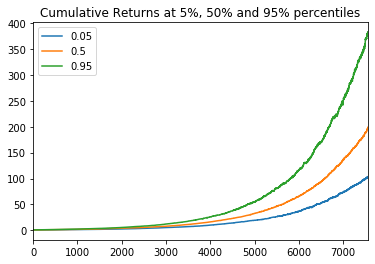

In [39]:
# Plot the cumulative returns over time
cum_returns_montecarlo.plot(title="Cumulative Returns at 5%, 50% and 95% percentiles")
#plt.savefig('./Images/cumulative_returns_percentile.png')

Optional Challenge — Early Retirement - Up to 10 bonus points
Harold is impressed with your work on this planner, but thinks that 30 years seems like a very long time to wait to retire! Harold wants to know if the retirement plan could be adjusted to retire earlier than normal. Try adjusting the portfolio to either include more risk (a higher stock than bond ratio), or to have a larger initial investment and then rerun the retirement analysis to see what it would take to retire in 5 years, instead of 30!


In [40]:
# Rerun Monte Carlo simulation with increased risk - AGG 25% and SPY 75%
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo_high_risk = pd.DataFrame()

# Run the Monte Carlo Simulation
for n in range(number_simulations):
    simulated_price_df = pd.DataFrame()
   
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252*30 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)

    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()

    #print(simulated_daily_returns)
    
    # Set the portfolio weights (25% AGG; 75% SPY)
    weights = [0.25, 0.75]

    # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    monte_carlo_high_risk[f"Simulation {n+1}"] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
monte_carlo_high_risk.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 491,Simulation 492,Simulation 493,Simulation 494,Simulation 495,Simulation 496,Simulation 497,Simulation 498,Simulation 499,Simulation 500
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995821,0.998695,0.994540,1.000521,1.015239,1.013169,0.995657,1.000237,1.012692,1.015026,...,0.999037,1.008832,1.012547,1.004114,0.989734,0.995708,1.008352,1.002805,0.993172,0.996526
2,0.998935,0.999533,0.995808,1.006950,1.009884,1.009097,0.994405,0.996995,1.022219,1.009301,...,1.003518,1.008134,1.015714,1.017429,0.992970,0.987073,1.016098,1.000222,0.993233,1.011397
3,0.992694,0.997075,0.996671,1.008983,1.011681,1.016349,0.993167,0.999811,1.026387,1.007027,...,1.010473,1.008269,1.018013,1.012747,0.980711,0.997166,1.018561,0.994766,1.004355,1.017497
4,1.001914,0.993143,0.994093,1.013843,1.006192,1.025570,1.000681,0.988960,1.031043,1.011600,...,1.013116,1.022161,1.029328,1.021912,0.983185,1.007776,1.019916,0.994491,1.003237,1.013809


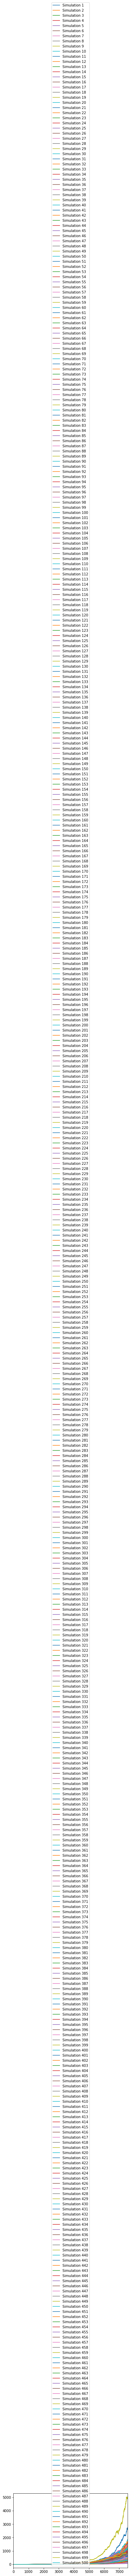

In [47]:
monte_carlo_high_risk.plot()

In [42]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumul_ret_high_risk = monte_carlo_high_risk.iloc[-1, :]
ending_cumul_ret_high_risk.head()

Simulation 1    406.921825
Simulation 2    452.695179
Simulation 3    207.015958
Simulation 4    564.327853
Simulation 5    220.166812
Name: 7560, dtype: float64

In [58]:
# Display the 90% confidence interval for the ending returns
confidence_interval_highrisk = ending_cumul_ret_high_risk.quantile(q=[0.05, 0.95])
confidence_interval_highrisk

0.05     206.856901
0.95    1078.215650
Name: 7560, dtype: float64

In [59]:
# Compute cumulative returns
cumul_ret_percentiles_high_risk = ending_cumul_ret_high_risk.quantile(q=[0.1, 0.5, 0.90])
print(f"Expected cumulative returns for high risk portfolio at 30 years for 10th, 50th and 90th percentiles: \n{cumul_ret_percentiles_high_risk}")

Expected cumulative returns for high risk portfolio at 30 years for 10th, 50th and 90th percentiles: 
0.1    239.519429
0.5    482.180489
0.9    927.688993
Name: 7560, dtype: float64


In [60]:
# Set initial investment
initial_investment = 20000

# Compute expected portfolio return
cumulative_pnl_high_risk = initial_investment * cumul_ret_percentiles_high_risk
cumulative_pnl_high_risk.astype(int)


0.1     4790388
0.5     9643609
0.9    18553779
Name: 7560, dtype: int32

In [61]:
# Determine if he can retire in 5 years instead of 30.

# Setup the Monte Carlo Parameters
number_simulations = 500
number_records_5yr = 252 * 5
monte_carlo_5year = pd.DataFrame()


In [49]:
# Run the Monte Carlo Simulation for 5 years
for n in range(number_simulations):
    simulated_price_df = pd.DataFrame()
   
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252*5 days
    for i in range(number_records_5yr):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)

    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()

    #print(simulated_daily_returns)
    
    # Set the portfolio weights (25% AGG; 75% SPY)
    weights = [0.25, 0.75]

    # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    monte_carlo_5year[f"Simulation {n+1}"] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
monte_carlo_5year.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 491,Simulation 492,Simulation 493,Simulation 494,Simulation 495,Simulation 496,Simulation 497,Simulation 498,Simulation 499,Simulation 500
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008278,1.002484,1.006626,1.004118,0.999590,1.009831,0.991569,0.996898,1.011539,1.001344,...,1.000758,0.995751,1.007027,0.996640,1.004560,1.005670,0.991163,1.000267,1.004269,1.000582
2,1.011756,0.997369,1.005422,1.005926,1.003811,1.018164,0.994497,0.997745,1.007377,0.999016,...,0.993503,1.000635,1.010459,0.999457,1.009225,1.009523,0.991272,1.003120,1.003121,1.016664
3,1.010260,0.991699,1.004429,1.006576,1.022143,1.022450,0.995613,1.009615,1.003409,0.991984,...,0.980871,0.996436,1.009004,1.002212,1.012166,1.008614,0.994387,1.007327,1.005325,1.012088
4,1.014036,0.989250,1.009503,1.014332,1.031463,1.032029,0.987520,1.019244,1.004183,0.997695,...,0.987234,0.991188,1.011175,1.011511,1.002752,1.004348,1.000074,0.999926,1.006392,1.021239


In [53]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumul_ret_5year = monte_carlo_5year.iloc[-1, :]
ending_cumul_ret_5year.head()

Simulation 1    3.167933
Simulation 2    3.008975
Simulation 3    3.918880
Simulation 4    2.597094
Simulation 5    3.376075
Name: 1260, dtype: float64

In [62]:
# Compute cumulative returns for 10, 50 and 90 percentile
cumul_ret_percentiles_5year = ending_cumul_ret_5year.quantile(q=[0.1, 0.5, 0.90])
print(f"Expected cumulative returns for high risk portfolio at 5 years for 10th, 50th and 90th percentiles: \n{cumul_ret_percentiles_high_risk}")

Expected cumulative returns for high risk portfolio at 5 years for 10th, 50th and 90th percentiles: 
0.1    239.519429
0.5    482.180489
0.9    927.688993
Name: 7560, dtype: float64


In [63]:
# Display the 90% confidence interval for the ending returns
confidence_interval_5year = ending_cumul_ret_5year.quantile(q=[0.05, 0.95])
confidence_interval_5year

0.05    1.992930
0.95    3.954932
Name: 1260, dtype: float64

In [64]:
# Set initial investment
initial_investment_5year = 20000

# Compute expected portfolio return
cumulative_pnl_5year = initial_investment_5year * cumul_ret_percentiles_5year
cumulative_pnl_5year.astype(int)

0.1    44115
0.5    56935
0.9    73078
Name: 1260, dtype: int32

In [78]:
# Set Plaid's projected income
projected_income = 7389

# Calculate the 4% withdrawal for the ending return as retirement income
return_withdrawal_5year = int(cumulative_pnl_5year.iloc[0]*0.04)
return_withdrawal_5year 
# Determine if the retirement income meets or exceeds the current projected income
if projected_income >= return_withdrawal_5year:
    print(f"The 4% withdrawal at the 10th percentile is ${return_withdrawal_5year}, which is less than projected income of ${projected_income}, so there will be too little funds to retire in 5 years")
else:
    print(f"The 4% withdrawal at the 10th percentile is ${return_withdrawal_5year}, which is more than projected income of ${projected_income}, so it would be possible to retire at years with an initial investment of {initial_investment_5year}")
    

The 4% withdrawal at the 10th percentile is $1764, which is less than projected income of $7389, so there will be too little funds to retire in 5 years


In [79]:
# Set initial investment
initial_investment_5year = 100000

# Compute expected portfolio return
cumulative_pnl_5year = initial_investment_5year * cumul_ret_percentiles_5year
cumulative_pnl_5year.astype(int)

0.1    220574
0.5    284686
0.9    365393
Name: 1260, dtype: int64

In [81]:
# Set Plaid's projected income
projected_income = 7389

# Calculate the 4% withdrawal for the ending return as retirement income
return_withdrawal_5year = int(cumulative_pnl_5year.iloc[0]*0.04)
return_withdrawal_5year 
# Determine if the retirement income meets or exceeds the current projected income
if projected_income >= return_withdrawal_5year:
    print(f"The 4% withdrawal at the 10th percentile is ${return_withdrawal_5year}, which is less than projected income of ${projected_income}, so there will be too little funds to retire in 5 years")
else:
    print(f"The 4% withdrawal at the 10th percentile is ${return_withdrawal_5year}, which is more than projected income of ${projected_income}, so it would be possible to retire at 5 years with an initial investment of ${initial_investment_5year}")
    

The 4% withdrawal at the 10th percentile is $8822, which is more than projected income of $7389, so it would be possible to retire at 5 years with an initial investment of $100000
